In [ ]:
#! nvidia-smi

In [81]:
#conda install pytorch torchvision -c pytorch

SyntaxError: invalid syntax (1301303582.py, line 2)

In [85]:
import os
def EXIT_NOTEBOOK(): os._exit(00)
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch 
from torch import nn
import torch.nn.functional as func
import seaborn as sns
import matplotlib.ticker

# # ps
# import pysindy as ps

# sns.set_theme()
torch.set_default_dtype(torch.float64)
plt.rcParams['text.usetex'] = True

# Set the vector field

In [90]:
def get_v(x):
    x = x[...,-1]
    return np.stack([3*x*np.exp(-2*x**2),3*x*np.exp(-2*x**2)-5*x],axis=-1)

In [92]:
dim = 1

# Dataset for X

In [95]:
X = np.random.uniform(-3,3,(10000,1))
get_v(X[0]),get_v(X[:2])

(array([-0.21002205,  5.74113648]),
 array([[-0.21002205,  5.74113648],
        [-0.55764439,  3.85493302]]))

# Set the NN model and Solver with training process

In [98]:
def relu2(X): return func.relu(X)**2
def tanh(X): return func.tanh(X)
class FCNN(nn.Module):
    def __init__(self,input_dim=2,output_dim=1,num_hidden=2,hidden_dim=10,act=func.tanh,transform=None):
        super().__init__()
         
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers  = nn.ModuleList([nn.Linear(input_dim,hidden_dim)])
        for _ in range(num_hidden-1): self.layers.append(nn.Linear(hidden_dim,hidden_dim))
        self.act     = act
        self.out     = nn.Linear(hidden_dim,output_dim)
        self.transform = transform
    def forward(self,X):
        if self.transform is not None: X = self.transform(X)
        for layer in self.layers: X = self.act(layer(X))
        Y = self.out(X)
        return Y
class Model(nn.Module):
    def __init__(self,dim,model_U,unit_len=int(5e3)):
        super().__init__()
        self.dim      = dim
        self.model_U  = model_U
        self.unit_len = unit_len
        self.mu       = nn.Parameter(torch.tensor([0.]*dim),requires_grad=False) 
        self.sigma    = nn.Parameter(torch.tensor([1.]*dim),requires_grad=False)
        #above two lines should work, but if something doesn't work, check here! Does current self.mu and self.sigma code work if dim>1. Should return a vector since what we're trying to do is calculate mu
        #and sigma separately for each imnputted feature. mu is parameter[0] for each row.
        self.coef_U   = nn.Parameter(torch.tensor(1.),requires_grad=False)
        #self.mu       = nn.Parameter(torch.tensor([0.]*dim).cuda(),requires_grad=False)
        #self.sigma    = nn.Parameter(torch.tensor([1.]*dim).cuda(),requires_grad=False)
        #self.coef_U   = nn.Parameter(torch.tensor(1.).cuda(),requires_grad=False)
    def get_U_harmonic(self,X): return torch.sum(X**2,axis=-1)


    def get_U_dU(self,X): #X is all data aka all positions
        I = int(np.ceil(len(X)/self.unit_len)) #will have to change the evenness of the split eventually. this is dividing up the data
        U,dU = [],[]
        for i in range(I):
            X_sub = X[i*self.unit_len:(i+1)*self.unit_len] #**needs changing for dimensionality. 1bead to 3bead
            if not torch.is_tensor(X_sub): X_sub = torch.tensor(X_sub,requires_grad=True)#.cuda()
            X_    = (X_sub-self.mu)/self.sigma
            U_    = self.coef_U*(self.model_U(X_).view(-1) + self.get_U_harmonic(X_))
            dU_   = torch.autograd.grad(U_,X_sub,torch.ones_like(U_),create_graph=True)[0] # it is X_sub!!!
            U.append(U_)
            dU.append(dU_)
        U = torch.hstack(U) #if U is a matrix instead of a scalar, will torch.hstack(U) stack the list that is in each element in U? Or something else.
        dU = torch.vstack(dU)
        return U,dU
    
    
    def get_U_np(self,X): 
        U,_ = self.get_U_dU(X);
        return U.cpu().data.numpy()
class Solver():
    def __init__(self,model):
        self.model=model
    def train_model(self,data_train,data_test,get_loss,optimizer,
                    n_steps,batch_size,scheduler=None,n_show_loss=100,error_model=None,use_tqdm=True):
        if use_tqdm: step_range = tqdm(range(n_steps))
        else: step_range = range(n_steps)
        loss_step = []
        for i_step in step_range:
            if i_step%n_show_loss==0:
                loss_train,loss_test = get_loss(self.model,data_train)[:-1],\
                                       get_loss(self.model,data_test)[:-1]
                
                def show_num(x): 
                    if abs(x)<100 and abs(x)>.01: return '%0.5f'%x
                    else: return '%0.2e'%x
                item1 = '%2dk'%np.int_(i_step/1000)
                item2 = 'Loss: '+' '.join([show_num(k) for k in loss_train])
                item3 = ' '.join([show_num(k) for k in loss_test])
                item4 = ''
                if error_model is not None: item4 = 'E(QP): %0.4f' % (error_model(self.model))
                print(', '.join([item1,item2,item3,item4]))
                loss_step = loss_step + [i_step] + [k.cpu().data.numpy() for k in loss_train]\
                                                 + [k.cpu().data.numpy() for k in loss_train]
            data_batch = data_train[random.sample(range(len(data_train)),
                                                  min(batch_size,len(data_train)))]
#             print(i_step,data_batch.shape)
            loss = get_loss(self.model,data_batch)[-1]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None: scheduler.step()
        if error_model is not None: 
            print("Error: %0.5f" % (error_model(self.model)))
        return loss_step

In [100]:
model_U = FCNN(input_dim=dim,output_dim=1,num_hidden=3,hidden_dim=10,act=tanh)#.cuda()
model   = Model(dim,model_U=model_U)#.cuda();
SOL     = Solver(model)

In [102]:
model.get_U_dU(X[:3])

(tensor([1.4081, 0.7709, 7.9047], grad_fn=<CatBackward0>),
 tensor([[-2.3792],
         [-1.7618],
         [ 5.6140]], grad_fn=<CatBackward0>))

# Set the loss function and Train the model for differen a_k(x)

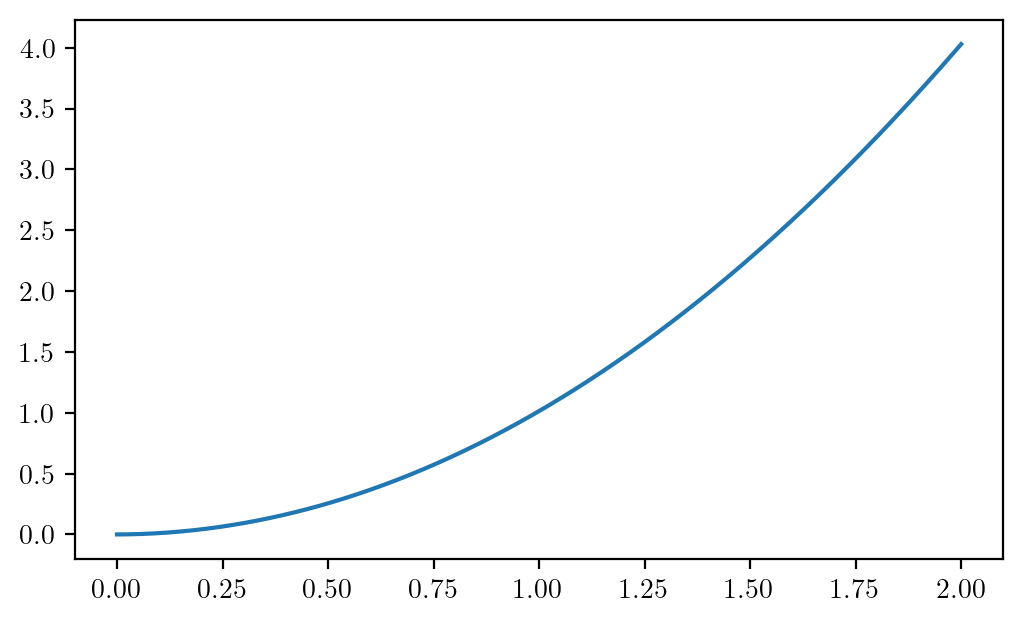

(tensor(788069.6223, grad_fn=<MeanBackward0>),
 tensor(788069.6223, grad_fn=<MeanBackward0>))

In [105]:
def plot_model(model,cmap='terrain',max_V = 10):
    
    xx     = np.linspace(0,2,1000).reshape(-1,1)
    U_NN   = model.get_U_np(xx)
    U_NN_min = U_NN.min()
    U_NN  = U_NN-U_NN_min

    fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
    c      = ax.plot(xx[:,0],U_NN,'-',lw=1.5,)

    ax.tick_params(axis="both", labelsize=10)
    plt.show()
#def get_a(X,k=choose_id):
#    if choose_id==1: return 2*torch.exp(-3*X**2)
#    if choose_id==2: return 2/(1+torch.exp(20*(torch.abs(X)-0.75)))
#    if choose_id==3: return 4/(1+torch.exp(20*(torch.abs(X)-0.75)))
def get_loss(model,data):

    X = data
    X = torch.tensor(X,requires_grad=True)#.cuda()
    _,dU = model.get_U_dU(X)

    #CTMC
    param = 3
    c = 0.5*param
    
    tmp1 = torch.detach(3*X*torch.exp(-2*X**2)) #common part of v1 and v2, aka v1
    tmp2 = torch.detach(-2*param/(1+torch.exp(20*(torch.abs(X)-0.75)))) #affinity fucntion
    #tmp2 = torch.detach(-get_a(X))
    tmp3 = torch.detach(-tmp2)
    tmp4 = torch.detach(tmp1-5*X) #v2
    Res = ( dU*(dU+tmp1)+tmp2 ) * (dU*(dU+tmp4)-c) - c*tmp3 #determinant 
    loss = torch.mean( Res**2 ) #norm of determinant -> loss function
    
    return loss#,loss
plot_model(model)
get_loss(model,X[:3])

Parameter containing:
tensor([0.]) Parameter containing:
tensor([1.]) Parameter containing:
tensor(1.)


  0%|          | 0/50001 [00:00<?, ?it/s]

 0k, Loss: 4.52e+05, 4.52e+05, 
 1k, Loss: 6.99e+02, 6.99e+02, 
 2k, Loss: 1.74e+02, 1.74e+02, 
 3k, Loss: 53.86561, 53.86561, 
 4k, Loss: 18.64283, 18.64283, 
 5k, Loss: 7.44694, 7.44694, 
 6k, Loss: 3.59940, 3.59940, 
 7k, Loss: 2.11037, 2.11037, 
 8k, Loss: 1.46065, 1.46065, 
 9k, Loss: 1.14332, 1.14332, 
10k, Loss: 0.96134, 0.96134, 
11k, Loss: 0.66976, 0.66976, 
12k, Loss: 0.45222, 0.45222, 
13k, Loss: 0.37754, 0.37754, 
14k, Loss: 0.31051, 0.31051, 
15k, Loss: 0.21163, 0.21163, 
16k, Loss: 0.10299, 0.10299, 
17k, Loss: 0.02543, 0.02543, 
18k, Loss: 3.58e-03, 3.58e-03, 
19k, Loss: 2.55e-03, 2.55e-03, 
20k, Loss: 2.19e-03, 2.19e-03, 
21k, Loss: 1.77e-03, 1.77e-03, 
22k, Loss: 1.49e-03, 1.49e-03, 
23k, Loss: 1.38e-03, 1.38e-03, 
24k, Loss: 1.21e-03, 1.21e-03, 
25k, Loss: 1.04e-03, 1.04e-03, 
26k, Loss: 7.97e-04, 7.97e-04, 
27k, Loss: 6.00e-04, 6.00e-04, 
28k, Loss: 5.81e-04, 5.81e-04, 
29k, Loss: 2.62e-03, 2.62e-03, 
30k, Loss: 4.05e-04, 4.05e-04, 
31k, Loss: 4.85e-04, 4.85e-04, 
32

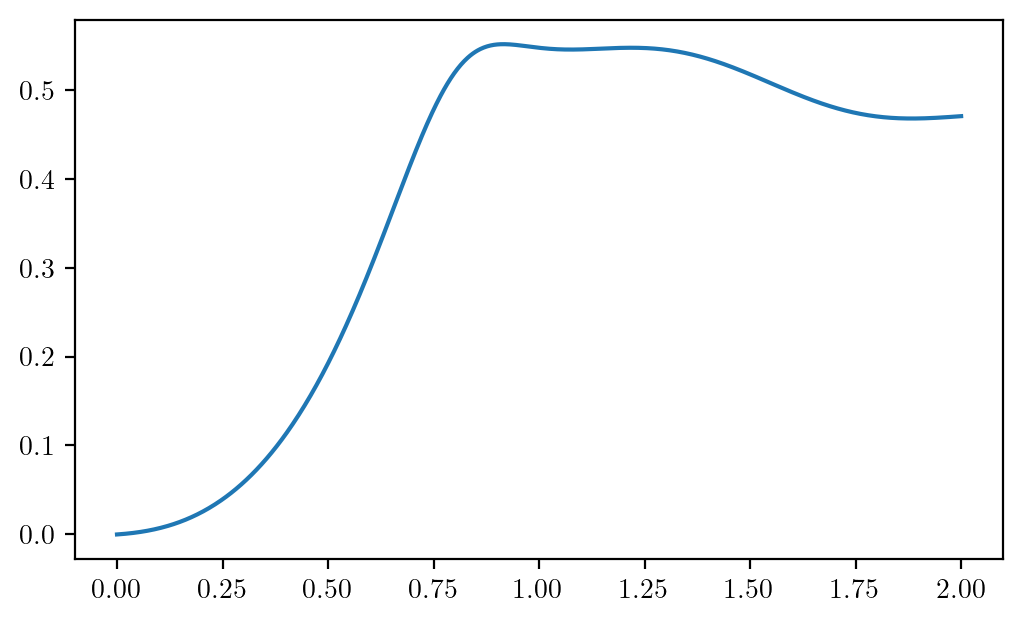

In [107]:
#for choose_id in [1,2,3]:
model_U = FCNN(input_dim=dim,output_dim=1,num_hidden=3,hidden_dim=10,act=tanh)#.cuda()
model   = Model(dim,model_U=model_U)#.cuda();
SOL     = Solver(model)

print(model.mu,model.sigma,model.coef_U)
    #optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(0.001).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(0.001))
scheduler = None
_loss_step = SOL.train_model(data_train=X,data_test=X,
                             get_loss=get_loss,optimizer=optimizer,scheduler=scheduler,
                             n_steps=int(5e4+1),batch_size=500,n_show_loss=1000,use_tqdm=True)
torch.cuda.empty_cache()
plot_model(model)
   # torch.save(model.state_dict(), "savee/model_"+str(choose_id))
#torch.save(model.state_dict(),"savee/model_anaconda3")

In [108]:
#torch.save(model.state_dict(), "savee/model_99")
#model.state_dict()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


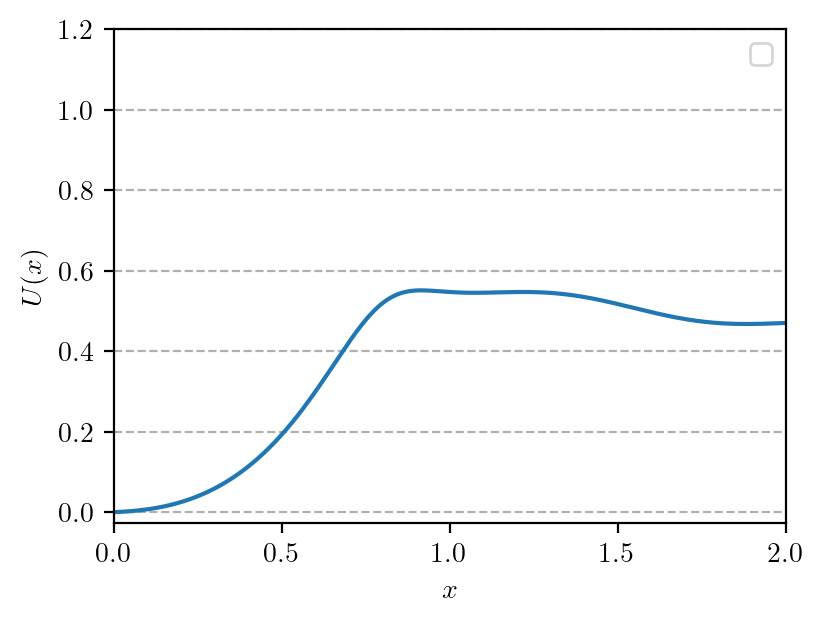

In [109]:
fig, ax  = plt.subplots(1,1,figsize=(4,3),dpi=200,constrained_layout=True)
xx       = np.linspace(0,2,1000).reshape(-1,1)
U_NN     = model.get_U_np(xx)
U_NN_min = U_NN.min()
U_NN     = U_NN-U_NN_min
c        = ax.plot(xx[:,0],U_NN,'-',lw=1.5)
ax.legend(fontsize=10)
ax.set_xlabel('$x$',fontsize=10)
ax.set_ylabel('$U(x)$',fontsize=10)
ax.set_xlim([0,2])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
ax.set_xticks([0,.5,1.,1.5,2])
ax.yaxis.grid(linestyle='--')
ax.tick_params(axis="both", labelsize=10)
plt.show()

In [113]:
U_NN

array([0.00000000e+00, 6.51119130e-05, 1.32658346e-04, 2.02677707e-04,
       2.75208498e-04, 3.50289310e-04, 4.27958826e-04, 5.08255811e-04,
       5.91219115e-04, 6.76887663e-04, 7.65300459e-04, 8.56496578e-04,
       9.50515163e-04, 1.04739543e-03, 1.14717665e-03, 1.24989815e-03,
       1.35559935e-03, 1.46431967e-03, 1.57609864e-03, 1.69097579e-03,
       1.80899073e-03, 1.93018311e-03, 2.05459260e-03, 2.18225895e-03,
       2.31322190e-03, 2.44752127e-03, 2.58519688e-03, 2.72628860e-03,
       2.87083631e-03, 3.01887993e-03, 3.17045941e-03, 3.32561471e-03,
       3.48438580e-03, 3.64681269e-03, 3.81293540e-03, 3.98279395e-03,
       4.15642838e-03, 4.33387875e-03, 4.51518511e-03, 4.70038754e-03,
       4.88952610e-03, 5.08264087e-03, 5.27977193e-03, 5.48095934e-03,
       5.68624320e-03, 5.89566356e-03, 6.10926051e-03, 6.32707410e-03,
       6.54914438e-03, 6.77551142e-03, 7.00621524e-03, 7.24129587e-03,
       7.48079334e-03, 7.72474763e-03, 7.97319876e-03, 8.22618668e-03,
      

In [30]:
import scipy.io as scio
from scipy.io import savemat


# Visualizing the results for different a_k(x)

/var/folders/14/40gccrfs5qvbpxcdp3fzdjt00000gn/T/ipykernel_96485/1776175810.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))

FileNotFoundError: [Errno 2] No such file or directory: 'savee/model_anaconda3'

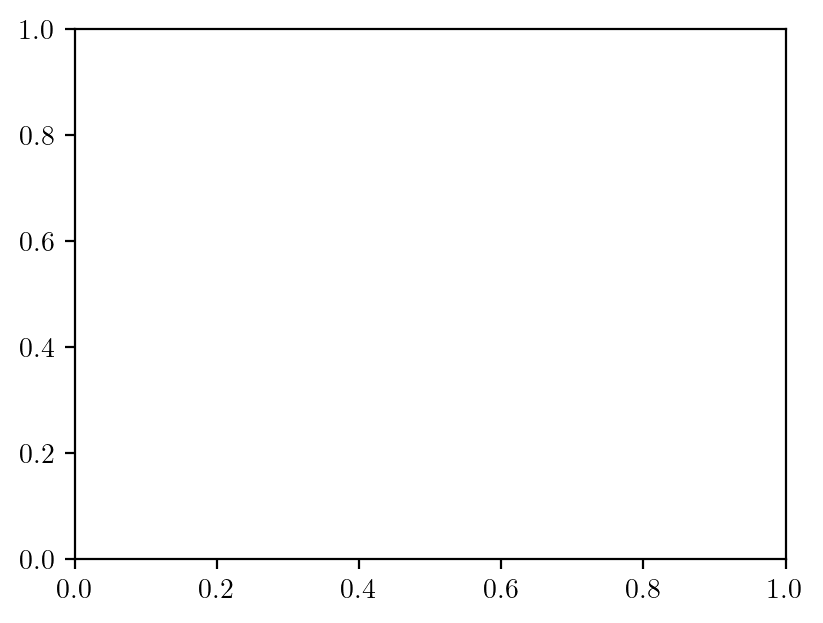

In [39]:
def plot_models(models):
    
    xx       = np.linspace(0,2,1000).reshape(-1,1)
    fig, ax  = plt.subplots(1,1,figsize=(4,3),dpi=200,constrained_layout=True)
    
    for k,model_name in enumerate(models):
        model.load_state_dict(torch.load(model_name))
        U_NN     = model.get_U_np(xx)
        U_NN_min = U_NN.min()
        U_NN     = U_NN-U_NN_min
        c        = ax.plot(xx[:,0],U_NN,'-',lw=1.5,label="$a_{%d}(x)$"%(k+1))
    ax.legend(fontsize=10)
    ax.set_xlabel('$x$',fontsize=10)
    ax.set_ylabel('$U(x)$',fontsize=10)
    ax.set_xlim([0,2])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
    ax.set_xticks([0,.5,1.,1.5,2])
    ax.yaxis.grid(linestyle='--')
    ax.tick_params(axis="both", labelsize=10)
    plt.show()
    
plot_models(["savee/model_anaconda3"])
#plot_models(["savee/model_a1_update", "savee/model_a2_update", "savee/model_a3_update", "savee/model_a4", "savee/model_a5_update"])

In [170]:
model

Model(
  (model_U): FCNN(
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1-2): 2 x Linear(in_features=10, out_features=10, bias=True)
    )
    (out): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [84]:
torch.load("/Users/annacoletti/Desktop/savee/model_a3_update.mat")

/var/folders/14/40gccrfs5qvbpxcdp3fzdjt00000gn/T/ipykernel_9056/187162749.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("/Users/annacoletti/Desktop/savee/mo

FileNotFoundError: [Errno 2] No such file or directory: '/Users/annacoletti/Desktop/savee/model_a3_update.mat'